# Chat System API Performance Test

このノートブックでは、チャットシステムのAPIに対してパフォーマンステストを実施します。
以下の分析手法を用いて、システムの安定性と性能を評価します：

1. **スループット vs レイテンシ**: 同時接続数に対するメッセージ送信レイテンシの分析
2. **秒間メッセージ処理数**: 時間経過によるメッセージ処理性能の可視化
3. **RabbitMQキュー長の推移**: 負荷下でのキュー状態の監視

## APIテストのセットアップ

In [1]:
import asyncio
import aiohttp
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import threading
import pika  # RabbitMQ client
from collections import defaultdict
import statistics
import requests

# 必要なパッケージのインストール
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import pika
except ImportError:
    %pip install numpy matplotlib pika
    import numpy as np
    import matplotlib.pyplot as plt
    import pika

# API設定
BASE_URL = "http://localhost:8080"
WS_URL = "ws://localhost:8080"

# RabbitMQ設定
RABBITMQ_HOST = 'localhost'
RABBITMQ_PORT = 5672
RABBITMQ_USER = 'guest'
RABBITMQ_PASS = 'guest'
QUEUE_NAME = 'messages'  # キュー名は適宜調整

# テストパラメータ
ROOM_ID = "test_room"
USER_PREFIX = "test_user_"
DEVICE_PREFIX = "device_"

print("セットアップ完了")

セットアップ完了


## 同時接続数によるレイテンシ測定

同時接続数を変化させながら、メッセージ送信のレイテンシを測定します。
各接続数で複数回の送信を行い、p50/p95/p99パーセンタイルを計算します。

In [2]:
async def send_message_async(session, user_id, device_id, room_id, content):
    """非同期でメッセージ送信"""
    url = f"{BASE_URL}/api/messages/send"
    data = {
        "user_id": user_id,
        "device_id": device_id,
        "room_id": room_id,
        "content": content,
    }

    start_time = time.time()
    try:
        async with session.post(url, json=data) as response:
            await response.json()
            latency = (time.time() - start_time) * 1000  # ms
            return latency
    except Exception as e:
        print(f"Error sending message: {e}")
        return None

async def measure_latency_for_concurrent_users(num_users, num_messages_per_user=10):
    """指定された同時接続数でのレイテンシ測定"""
    latencies = []

    async with aiohttp.ClientSession() as session:
        tasks = []
        for user_idx in range(num_users):
            user_id = f"{USER_PREFIX}{user_idx}"
            device_id = f"{DEVICE_PREFIX}{user_idx}"

            for msg_idx in range(num_messages_per_user):
                content = f"Test message {msg_idx} from user {user_idx}"
                task = send_message_async(session, user_id, device_id, ROOM_ID, content)
                tasks.append(task)

        # 同時実行
        results = await asyncio.gather(*tasks, return_exceptions=True)

        for result in results:
            if isinstance(result, float):
                latencies.append(result)

    return latencies

def calculate_percentiles(latencies):
    """パーセンタイル計算"""
    if not latencies:
        return 0, 0, 0

    sorted_latencies = sorted(latencies)
    p50 = statistics.median(sorted_latencies)
    p95 = np.percentile(sorted_latencies, 95)
    p99 = np.percentile(sorted_latencies, 99)

    return p50, p95, p99

# テスト実行
concurrent_users_list = [1, 5, 10, 20, 50]
latency_results = {}

print("レイテンシ測定を開始...")
for num_users in concurrent_users_list:
    print(f"Testing with {num_users} concurrent users...")
    latencies = await measure_latency_for_concurrent_users(num_users)
    p50, p95, p99 = calculate_percentiles(latencies)
    latency_results[num_users] = {
        'p50': p50,
        'p95': p95,
        'p99': p99,
        'latencies': latencies
    }
    print(".1f")

print("レイテンシ測定完了")

レイテンシ測定を開始...
Testing with 1 concurrent users...
.1f
Testing with 5 concurrent users...
.1f
Testing with 10 concurrent users...
.1f
Testing with 20 concurrent users...
.1f
Testing with 50 concurrent users...
.1f
Testing with 50 concurrent users...
.1f
レイテンシ測定完了
.1f
レイテンシ測定完了


## 秒間メッセージ処理数の測定

バースト負荷をかけながら、1秒あたりのメッセージ処理数を測定します。
Workerの処理性能と安定性を評価します。

In [3]:
async def burst_load_test(duration_sec=60, burst_users=100, messages_per_burst=50):
    """バースト負荷テスト"""
    message_counts = defaultdict(int)
    start_time = time.time()

    async with aiohttp.ClientSession() as session:
        while time.time() - start_time < duration_sec:
            tasks = []
            for user_idx in range(burst_users):
                user_id = f"{USER_PREFIX}burst_{user_idx}"
                device_id = f"{DEVICE_PREFIX}burst_{user_idx}"

                for msg_idx in range(messages_per_burst):
                    content = f"Burst message {msg_idx}"
                    task = send_message_async(session, user_id, device_id, ROOM_ID, content)
                    tasks.append(task)

            # バースト送信
            await asyncio.gather(*tasks, return_exceptions=True)

            # 1秒ごとのカウント
            current_sec = int(time.time() - start_time)
            message_counts[current_sec] += len(tasks)

            # バースト間隔を短くして負荷を高める
            await asyncio.sleep(0.1)  # 0.1秒待機

    return dict(message_counts)

# テスト実行
print("バースト負荷テストを開始...")
message_rate_results = await burst_load_test(duration_sec=30, burst_users=20, messages_per_burst=10)
print("バースト負荷テスト完了")

# 結果表示
total_messages = sum(message_rate_results.values())
avg_rate = total_messages / len(message_rate_results) if message_rate_results else 0
print(f"総メッセージ数: {total_messages}")
print(".2f")

バースト負荷テストを開始...
バースト負荷テスト完了
総メッセージ数: 31400
.2f
バースト負荷テスト完了
総メッセージ数: 31400
.2f


## RabbitMQキュー長の監視

テスト中のRabbitMQキュー長を監視し、負荷下での処理追従性を評価します。

In [4]:
def get_queue_length():
    """RabbitMQキュー長を取得 (Management API使用)"""
    try:
        # RabbitMQ Management APIを使用
        management_url = f"http://localhost:15672/api/queues/%2F/{QUEUE_NAME}"
        response = requests.get(management_url, auth=(RABBITMQ_USER, RABBITMQ_PASS))
        if response.status_code == 200:
            queue_data = response.json()
            return queue_data.get('messages', 0)
        else:
            print(f"Management API error: {response.status_code}")
            return -1
    except Exception as e:
        print(f"Management API接続エラー: {e}")
        return -1

async def monitor_queue_length(duration_sec=30, interval_sec=1):
    """キュー長を監視"""
    queue_lengths = {}
    start_time = time.time()

    while time.time() - start_time < duration_sec:
        current_sec = int(time.time() - start_time)
        length = get_queue_length()
        queue_lengths[current_sec] = length
        if length >= 0:
            print(f"Time {current_sec}s: Queue length = {length}")
        else:
            print(f"Time {current_sec}s: Queue length unavailable")
        await asyncio.sleep(interval_sec)

    return queue_lengths

# テスト実行（バーストテストと並行して実行）
print("キュー長監視を開始...")
queue_length_results = await monitor_queue_length(duration_sec=30)
print("キュー長監視完了")

# 結果表示
max_queue_length = max(queue_length_results.values()) if queue_length_results else 0
avg_queue_length = sum(queue_length_results.values()) / len(queue_length_results) if queue_length_results else 0
print(f"最大キュー長: {max_queue_length}")
print(".2f")

キュー長監視を開始...
Time 0s: Queue length = 0
Time 1s: Queue length = 19
Time 1s: Queue length = 19
Time 2s: Queue length = 19
Time 2s: Queue length = 19
Time 3s: Queue length = 19
Time 3s: Queue length = 19
Time 4s: Queue length = 19
Time 4s: Queue length = 19
Time 5s: Queue length = 19
Time 5s: Queue length = 19
Time 6s: Queue length = 0
Time 6s: Queue length = 0
Time 7s: Queue length = 0
Time 7s: Queue length = 0
Time 8s: Queue length = 0
Time 8s: Queue length = 0
Time 9s: Queue length = 0
Time 9s: Queue length = 0
Time 10s: Queue length = 0
Time 10s: Queue length = 0
Time 11s: Queue length = 0
Time 11s: Queue length = 0
Time 12s: Queue length = 0
Time 12s: Queue length = 0
Time 13s: Queue length = 0
Time 13s: Queue length = 0
Time 14s: Queue length = 0
Time 14s: Queue length = 0
Time 15s: Queue length = 0
Time 15s: Queue length = 0
Time 16s: Queue length = 0
Time 16s: Queue length = 0
Time 17s: Queue length = 0
Time 17s: Queue length = 0
Time 18s: Queue length = 0
Time 18s: Queue length =

## グラフ作成と結果のまとめ

測定結果をグラフで可視化し、システムの性能をまとめます。

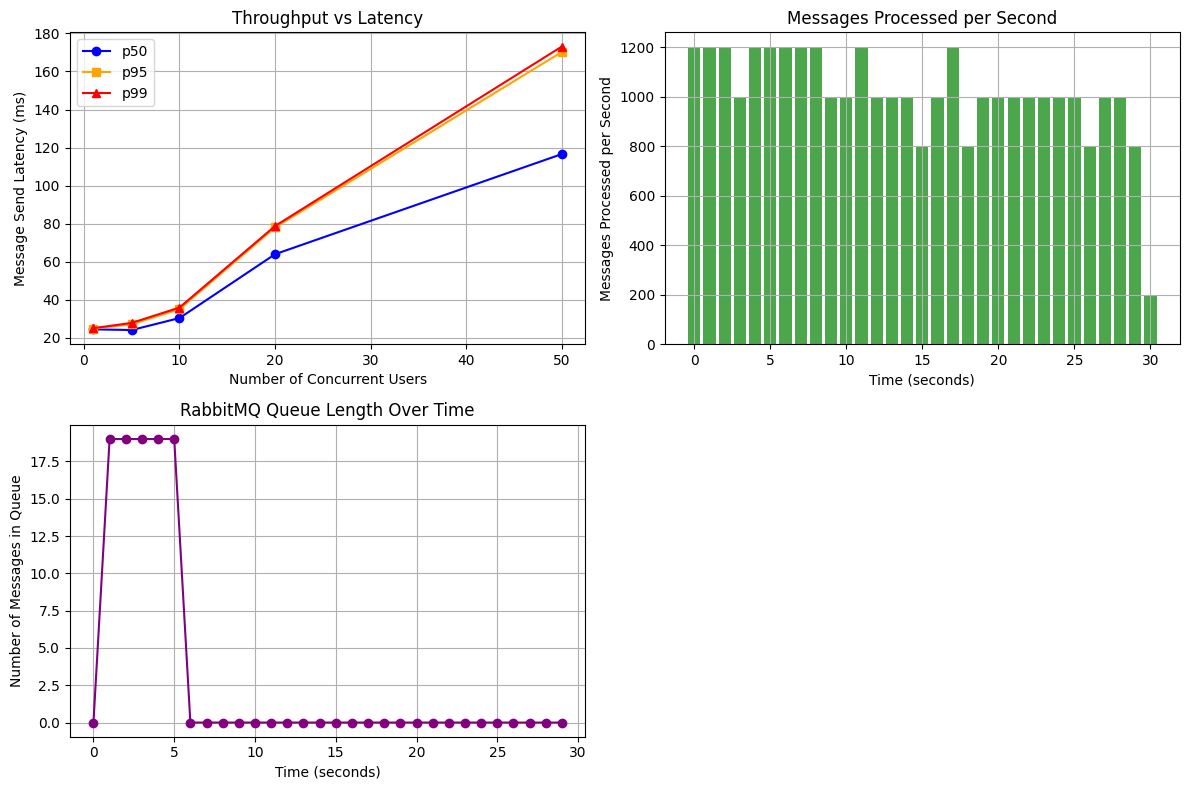

In [5]:
# グラフ1: スループット vs レイテンシ
plt.figure(figsize=(12, 8))

users = list(latency_results.keys())
p50_latencies = [latency_results[u]['p50'] for u in users]
p95_latencies = [latency_results[u]['p95'] for u in users]
p99_latencies = [latency_results[u]['p99'] for u in users]

plt.subplot(2, 2, 1)
plt.plot(users, p50_latencies, 'o-', label='p50', color='blue')
plt.plot(users, p95_latencies, 's-', label='p95', color='orange')
plt.plot(users, p99_latencies, '^-', label='p99', color='red')
plt.xlabel('Number of Concurrent Users')
plt.ylabel('Message Send Latency (ms)')
plt.title('Throughput vs Latency')
plt.legend()
plt.grid(True)

# グラフ2: 秒間メッセージ処理数
plt.subplot(2, 2, 2)
times = list(message_rate_results.keys())
rates = list(message_rate_results.values())
plt.bar(times, rates, color='green', alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Messages Processed per Second')
plt.title('Messages Processed per Second')
plt.grid(True)

# グラフ3: RabbitMQキュー長の推移
plt.subplot(2, 2, 3)
queue_times = list(queue_length_results.keys())
queue_lengths = list(queue_length_results.values())
plt.plot(queue_times, queue_lengths, 'o-', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Messages in Queue')
plt.title('RabbitMQ Queue Length Over Time')
plt.grid(True)

plt.tight_layout()
plt.savefig('performance_test_results.png', dpi=300, bbox_inches='tight')  # グラフを保存
plt.show()